In [379]:
# importing packages and data set

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

microbe_dataSet = pd.read_csv('data/mimedb_microbes.csv')
disbiome_dataSet = pd.read_csv('data/disbiome_data.csv')

# Understanding Microbiome Data Set

## Data Schema:

| **Column Name**          | **Description**                                          |
|--------------------------|----------------------------------------------------------|
| **id**                   | Unique identifier for each record                        |
| **microbe_id**           | Identifier for the microbe                               |
| **name**                 | The name of the microbe                                  |
| **superkingdom**         | The broader superkingdom classification                  |
| **kingdom**              | The biological kingdom to which the microbe belongs      |
| **phylum**               | The phylum classification of the microbe                 |
| **klass**                | The class classification of the microbe                  |
| **order**                | The order classification of the microbe                  |
| **family**               | The family classification of the microbe                 |
| **genus**                | The genus classification of the microbe                  |
| **species**              | The species of the microbe                               |
| **strain**               | The strain or subtype of the microbe                     |
| **parent_id**            | Identifier for the parent record (if applicable)         |
| **level**                | Hierarchical level or classification                     |
| **ncbi_tax_id**          | The NCBI taxonomy identifier for the microbe             |
| **activity**             | Indicates if the microbe is active or inactive           |
| **gram**                 | Gram staining characteristic (positive or negative)      |
| **oxygen_requirement**   | The type of oxygen requirement for the microbe           |
| **metabolism**           | The metabolic characteristics of the microbe             |
| **shape**                | The shape of the microbe (e.g., cocci, bacilli)          |
| **mobility**             | Indicates if the microbe is mobile or immobile           |
| **flagella_presence**    | Indicates the presence or absence of flagella            |
| **number_of_membranes**  | Number of membranes the microbe has                      |
| **optimal_temperature**  | The optimal temperature for the microbe's growth         |
| **temperature_range**    | The temperature range within which the microbe can grow  |
| **habitat**              | The natural habitat of the microbe                       |
| **biotic_relationship**  | The type of biotic relationship the microbe has          |
| **cell_arrangement**     | The arrangement of cells in the microbe                  |
| **sporulation**          | Indicates if the microbe can form spores                 |
| **energy_source**        | The type of energy source used by the microbe            |
| **background**           | Additional background information about the microbe      |
| **health_type**          | Indicates the health implications (e.g., pathogenic)     |
| **evidence_type**        | The type of evidence supporting the microbe's classification |
| **data_source**          | The source of the data                                   |
| **export**               | Export status or related information                     |
| **human_pathogen**       | Indicates if the microbe is a human pathogen             |
| **genome_ids**           | Associated genome identifiers                            |
| **created_at**           | The date and time when the record was created            |
| **updated_at**           | The date and time when the record was last updated       |

(P.S Generated by ChatGPT)

# Data Cleaning

In [380]:
def cleaning_oxy_req(ele):
    '''
    cleaned the input ele
    '''
    regex_pattern = r"/|;|,"

    if isinstance(ele, str):
        
        ele = re.split(regex_pattern, ele)[0]
        ele = ele.replace('\xa0', ' ')
        if ele == 'Nanaerobe':
            return 'Anaerobe'
        elif ele == 'Obligate anaerobe':
            return 'Anaerobe'
        elif ele == 'Facultatively anaerobe':
            return 'Facultative anaerobe'
        elif ele == 'Microaerophile':
            return 'Microaerophilic'
        else:
            return ele
    else:
        return ele

In [381]:
cleaned_microbe_dataSet = microbe_dataSet.copy()

# reduing the dimension of the oxygen_requirements types
# there is correct type and take the dominate type
cleaned_microbe_dataSet['oxygen_requirement'] = microbe_dataSet['oxygen_requirement'].apply(cleaning_oxy_req)

# find the association between the microbe and the source
# the source will be the most frequent source
taxid_sources = disbiome_dataSet[['subject_taxid', 'association_sources']].dropna().groupby(['subject_taxid']).apply(lambda df: df.value_counts().idxmax()[1]).reset_index().rename(columns={0: 'association_sources'})

# convert 'created_at' 
cleaned_microbe_dataSet['created_at_m'] = cleaned_microbe_dataSet['created_at'].apply(lambda time : pd.Timestamp(time).to_period('M').month)
cleaned_microbe_dataSet['update_at_m'] = cleaned_microbe_dataSet['updated_at'].apply(lambda time : pd.Timestamp(time).to_period('M').month)

# merging the two data set
complete_microbe_sources = pd.merge(cleaned_microbe_dataSet, taxid_sources, left_on='ncbi_tax_id', right_on='subject_taxid', how='inner')
incomeplete_microbe_sources = pd.merge(cleaned_microbe_dataSet, taxid_sources, left_on='ncbi_tax_id', right_on='subject_taxid', how='left')
complete_microbe_sources['tax_id'] = complete_microbe_sources['ncbi_tax_id']
complete_microbe_sources = complete_microbe_sources.drop(columns=['ncbi_tax_id', 'subject_taxid'])
incomeplete_microbe_sources['tax_id'] = incomeplete_microbe_sources['ncbi_tax_id']
incomeplete_microbe_sources = incomeplete_microbe_sources.drop(columns=['ncbi_tax_id', 'subject_taxid'])

## Evaluating the Degree of Missingness of each column

### Visualizing Missing Value

In [382]:
# predefined functions

def eval_missing(df):
    '''
    find the porportion of missingness of each column in the table.
    return the result as a series
    '''
    summary = df.isna().mean()

    summary.sort_values().plot(kind = 'barh', figsize=(10, 10))
    # Adding title and labels
    plt.title('Percentage of missing values in each column')
    plt.xlabel('Columns')
    plt.ylabel('Percentage of missing values')

    plt.axvline(x=0.4, color='r', linestyle='--', linewidth=2)
    plt.show()

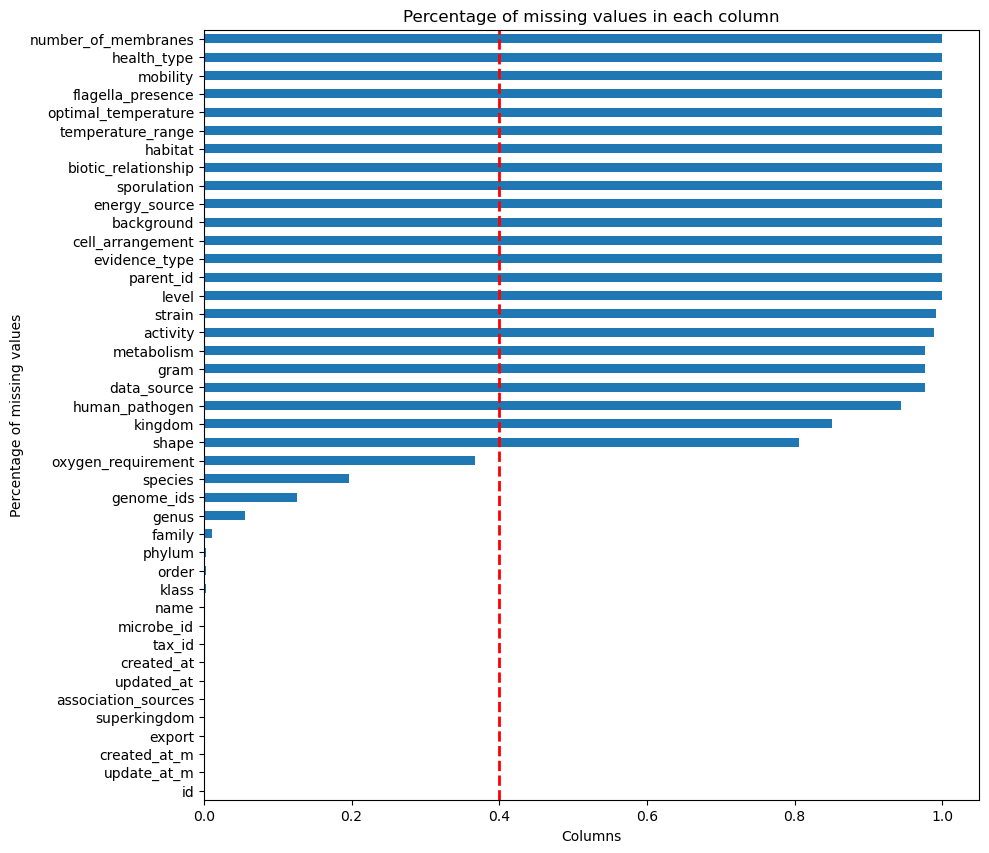

In [383]:
eval_missing(complete_microbe_sources)

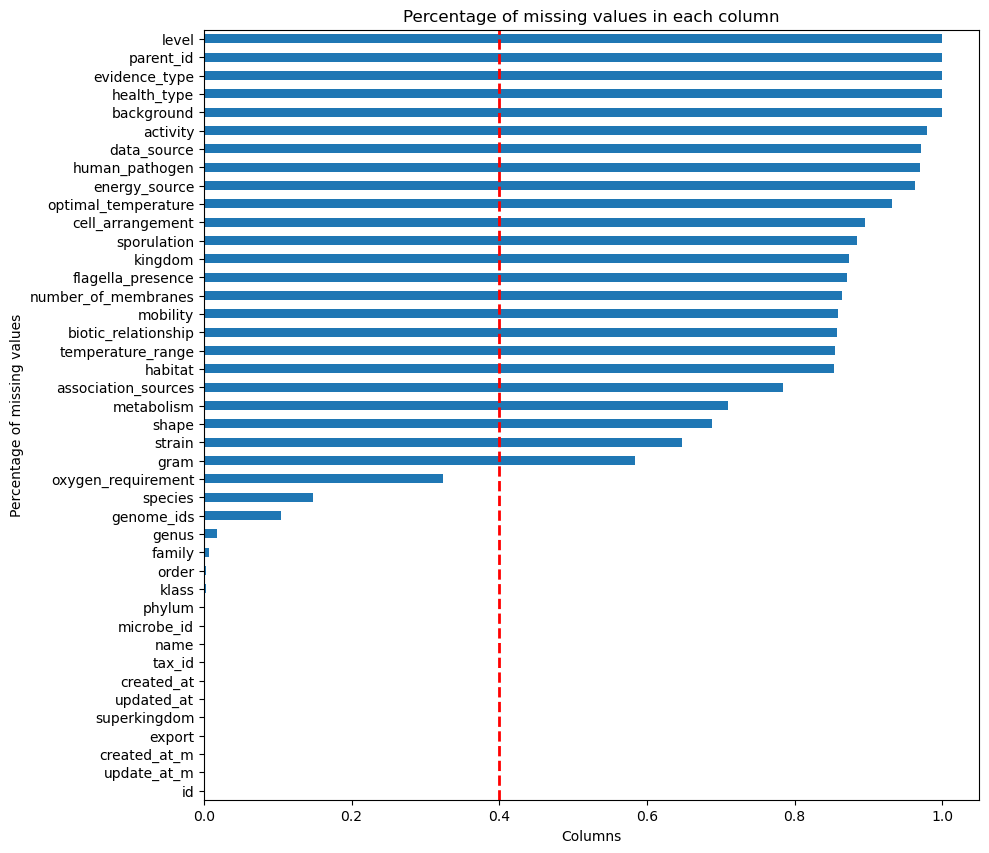

In [384]:
eval_missing(incomeplete_microbe_sources)

### Filtering Out columns that has more than 40% missing value and other identifier

In [385]:
filtered_complete_ms = complete_microbe_sources.drop(columns=complete_microbe_sources.columns[complete_microbe_sources.isna().mean() > 0.4])
filtered_incomplete_ms = incomeplete_microbe_sources.drop(columns=incomeplete_microbe_sources.columns[incomeplete_microbe_sources.isna().mean() > 0.4])

### Assessing the dependency of Missing rate in oxygen_requirements to other categorical columns

In [386]:
# conducting TVD analysis of column with missingness against others
def tvd_testing(missing_col, testingCol):
    '''
    Conduct TVD analysis of the missingness of a column against another column.
    return the TVD value
    ---
    missing_col: pd.Series
        the column with missingness
    testingCol: pd.Series
        the column to test against
    ---
    return: float
        the TVD value
    '''
    missing_mask = missing_col.isnull()

    missing_testingCol_prop = testingCol[missing_mask].value_counts(normalize=True)
    unMissing_testingCol_prop = testingCol[~missing_mask].value_counts(normalize=True)

    # find all categories for the purpose of comparsion
    all_tvd_categories = missing_testingCol_prop.index.union(unMissing_testingCol_prop.index)
    missing_testingCol_prop = missing_testingCol_prop.reindex(all_tvd_categories, fill_value=0)
    unMissing_testingCol_prop = unMissing_testingCol_prop.reindex(all_tvd_categories, fill_value=0)

    return np.abs(missing_testingCol_prop - unMissing_testingCol_prop).sum() / 2

In [387]:
tvd_testing_col = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass', 'order', 'family', 'genus', 'gram', 'export']

# check unqiue values for potential MAR columns
uniqueness = pd.DataFrame(columns=['column', 'unique_values'])
for col in tvd_testing_col:
    uniqueness = uniqueness.append({'column': col, 'unique_values': len(cleaned_microbe_dataSet[col].unique())}, ignore_index=True)
uniqueness.sort_values(by='unique_values')

,column,unique_values
9,export,1
0,superkingdom,4
2,update_at_m,4
1,created_at_m,7
8,gram,7
3,phylum,37
4,klass,80
5,order,159
6,family,299
7,genus,561


In [388]:
tvd_testing_col = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass', 'gram']


# conduct TVD analysis
tvd_results = pd.DataFrame(columns = ['column', 'tvd'])
for colName in tvd_testing_col:
    tvd = tvd_testing(complete_microbe_sources['oxygen_requirement'], complete_microbe_sources[colName])
    tvd_results = tvd_results.append({'column': colName, 'tvd': tvd}, ignore_index=True)
tvd_results.sort_values(by='tvd', ascending=False)

,column,tvd
5,gram,0.500000
4,klass,0.499170
3,phylum,0.424708
0,superkingdom,0.412791
2,update_at_m,0.395349
1,created_at_m,0.336109


Interpretation:
- High tvd value indicating great difference on the distribution of categories of the missing and non-missing value
- genus, family, order, klass might be miss leading due to its scarsity
- these columns can be used to predict the oxygen_requirements

## Data Imputation

In [389]:
# repalce all the missing value with the most frequent value
simple_imputation_df = filtered_complete_ms.copy()
simple_imputation_df['oxygen_requirement'] = simple_imputation_df['oxygen_requirement'].fillna(simple_imputation_df['oxygen_requirement'].value_counts().index[0])

In [390]:
# replace all the missing value based on the probabilistic model of the pre-exist data
prob_imputation_df = filtered_complete_ms.copy()
choices = np.array(prob_imputation_df['oxygen_requirement'].value_counts(normalize=True).index)
prob = np.array(prob_imputation_df['oxygen_requirement'].value_counts(normalize=True))
impute_value = np.random.choice(a = choices, size = prob_imputation_df['oxygen_requirement'].isna().sum(), p=prob)
prob_imputation_df.loc[prob_imputation_df['oxygen_requirement'].isna(), 'oxygen_requirement'] = impute_value

In [391]:
#TODO

## Imputation evaluation

In [392]:
CRITICAL_COL = ['superkingdom', 'created_at_m', 'update_at_m', 'phylum', 'klass', 'oxygen_requirement', 'association_sources']

In [393]:
def logistic_regression_classification(df):
    '''
    TODO
    '''

    train = df[CRITICAL_COL]
    train = df.dropna()

    X = pd.get_dummies(train.drop('association_sources', axis=1), drop_first=True)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(train['association_sources'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)


In [394]:
def naiveBased_classification(df):
    '''
    TODO
    '''
    return 0.0

In [395]:
complete_microbe_sources

,id,name,microbe_id,species,kingdom,phylum,activity,gram,oxygen_requirement,created_at,...,data_source,export,human_pathogen,genome_ids,parent_id,level,created_at_m,update_at_m,association_sources,tax_id
0,6,Acinetobacter baumannii,MMDBm0000006,Acinetobacter baumannii,NaN,Proteobacteria,NaN,NaN,NaN,2020-09-25 23:53:13.068290,...,NaN,1,NaN,1096,NaN,NaN,9,8,subgingival plaque,470
1,14,Akkermansia muciniphila,MMDBm0000014,Akkermansia muciniphila,NaN,Verrucomicrobia,NaN,NaN,Anaerobe,2020-09-26 05:00:38.840888,...,NaN,1,NaN,1343,NaN,NaN,9,8,feces,239935
2,22,Anaerostipes hadrus,MMDBm0000022,Anaerostipes hadrus,NaN,Firmicutes,NaN,NaN,Anaerobe,2020-09-26 05:00:38.897394,...,NaN,1,NaN,2075,NaN,NaN,9,8,feces,649756
3,36,Bacteroides caccae,MMDBm0000036,Bacteroides caccae,NaN,Bacteroidetes,NaN,NaN,Anaerobe,2020-09-26 05:00:39.008917,...,NaN,1,NaN,1099,NaN,NaN,9,8,feces,47678
4,38,Bacteroides cellulosilyticus,MMDBm0000038,Bacteroides cellulosilyticus,NaN,Bacteroidetes,NaN,NaN,Anaerobe,2020-09-26 05:00:39.030080,...,NaN,1,NaN,1345,NaN,NaN,9,8,feces,246787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,809110,Mitsuokella jalaludinii,MMDBm0809110,Mitsuokella jalaludinii,NaN,Firmicutes,NaN,NaN,Anaerobe,2021-02-12 10:45:50.125548,...,NaN,1,NaN,1328,NaN,NaN,2,8,feces,187979
464,809583,Dialister pneumosintes,MMDBm0809583,Dialister pneumosintes,NaN,Firmicutes,NaN,NaN,NaN,2021-02-12 10:50:36.344515,...,NaN,1,NaN,1056,NaN,NaN,2,8,subgingival plaque,39950
465,809586,Dialister succinatiphilus,MMDBm0809586,Dialister succinatiphilus,NaN,Firmicutes,NaN,NaN,Anaerobe,2021-02-12 10:50:37.831266,...,NaN,1,NaN,2007,NaN,NaN,2,8,feces,487173
466,809637,Megasphaera elsdenii,MMDBm0809637,Megasphaera elsdenii,NaN,Firmicutes,NaN,NaN,Anaerobe,2021-02-12 10:51:03.260719,...,NaN,1,NaN,1282,NaN,NaN,2,8,feces,907


In [396]:
def imputation_eval(imputed_df : dict, ml_models : dict):
    '''
    evaluting the performance of multiple models on the data set with different degree of imputation
    ---
    imputed_df: dictionary of pd.DataFrame 
        where the key is the imputation method and the value is the imputed data set
    ml_models: dictionary of functions with signature (X_train, y_train, X_test, y_test) -> float
        where the key is the model name and the value is the model function
    ---
    return: pd.DataFrame
        the result of the evaluation
    '''
    eval_result = pd.DataFrame(columns=['imputation_method', 'model', 'accuracy'])
    for impute_method, df in imputed_df.items():
        for modelName, model in ml_models.items():
            eval_result = eval_result.append({'imputation_method': impute_method, 'model': modelName, 'accuracy': model(df)},
                                              ignore_index=True)
    return eval_result

In [397]:
imputation_eval({'non_imputation': filtered_complete_ms, 
                    'simple_imputation': simple_imputation_df, 
                    'simple_prob_imputation': prob_imputation_df}, 
                {'logistic classification': logistic_regression_classification})

/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/scripps_microbiome/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

,imputation_method,model,accuracy
0,non_imputation,logistic classification,0.490566
1,simple_imputation,logistic classification,0.569444
2,simple_prob_imputation,logistic classification,0.569444


In [398]:
import pandas as pd
from fancyimpute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder

cleaned_microbe_dataSet



encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(cleaned_microbe_dataSet[['oxygen_requirement']])

imputer = IterativeImputer()
imputed_data = imputer.fit_transform(encoded_data)

imputed_df = pd.DataFrame(imputed_data, columns=encoder.get_feature_names_out(['oxygen_requirement']))
imputed_df['oxygen_requirement'] = imputed_df.idxmax(axis=1).str.replace('oxygen_requirement_', '')

print(imputed_df[['oxygen_requirement']])

ModuleNotFoundError: No module named 'fancyimpute'

# Testing performance